# Prediction of craft beer price in polish pubs

Aim of this project is to predict pub price for craft beer.

Scope of project are pubs which are placing their pricelist on ontap.pl portal - polish aggregator for pubs beer

## Source data

Data has been scrapped from ontap.pl site

### Basic imports

In [1]:
import time
import numpy as np
import pandas as pd
import re

# statistics
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors

# plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn classes
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# modelling metrics
from sklearn.metrics import r2_score, mean_squared_error

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

### Function definitions - used in feature engineering part

In [2]:
def on_tap_since_to_days(on_tap_since):
    if on_tap_since[-1] == 'd':
        return float(on_tap_since[:-1])
    elif on_tap_since[-1] =='h':
        return float(on_tap_since[:-1])/24

def retrieve_plato_from_platoabv(plato_abv):
    if plato_abv:
        plato_abv = plato_abv.replace(' ', '').replace('?', '')
        plato = re.findall('(\d*[.,]*\d*)°', plato_abv)
        if plato and plato[0].replace(',', '.'):
            plato = float(plato[0].replace(',', '.'))
        else:
            plato= np.NaN
    else:
        plato = np.NaN
    return plato

def retrieve_abv_from_platoabv(plato_abv):
    plato_abv = plato_abv.replace(' ', '')
    abv = re.findall('(\d*[.,]*\d*)%', plato_abv)
    abv = float(abv[0].replace(',', '.')) if abv else ''
    return abv

def retrieve_500ml_price_from_prices(prices):
    price500ml = re.findall('0.5l: (.*?)zł', prices)[0] if re.findall('0.5l: (.*?)zł', prices) else ''
    price500ml = price500ml.replace(',', '.')
    return price500ml

def retrieve_ibu_from_portals(portals):
    ibu =  re.findall('(\d*) IBU', portals)[0] if re.findall('(\d*) IBU', portals) else ''
    ibu = ibu.replace(',', '.')
    return ibu

def retrieve_rb_from_portals(portals):
    rb = re.findall('.*rb:(\d*.\d*)', portals)[0] if re.findall('.*rb:(\d*.\d*)', portals) else ''
    rb = rb.replace(',', '.')
    return rb

def retrieve_untappd_from_portals(portals):
    untappd = re.findall('.*u:(\d*.\d*)', portals)[0] if re.findall('.*u:(\d*.\d*)', portals) else ''
    untappd = untappd.replace(',', '.')
    return untappd

# Exploratory Data Analysis

In [3]:
df = pd.read_json('ontap_data_with_rb_scrapped.json')

In [4]:
df.sample(5)

,beer_name,brewery,city,on_tap_since,plato_abv,portals_rates,prices,pub_name,style,rb_style,rb_abv,rb_score,rb_style_perc,rb_reviews_no
223,polski krafcik vol. 7,deer bear,gdańsk,7d,6%,u:3.3,0.3l: 12zł · 0.5l: 16zł,labeerynt,Belgian IPA,None,NaN,NaN,NaN,NaN
2331,kazimierz orange,kazimierz,wrocław,1d,"14° 5,9%",rb:46 u:3.7,0.15l: 5zł · 0.3l: 10zł · 0.5l: 13zł,szynkarnia,APA z pomarańczą,Pale Ale - American / APA,5.9,3.18,41.0,11.0
497,citron,litovel,kraków,3d,"4,0%",rb:3 u:3.1,0.3l: 6zł · 0.5l: 8zł,artefakt,Ciemny Lager,Flavored - Fruit,4.0,2.09,5.0,27.0
1996,wkd grodzisk,bazyliszek,warszawa,1d,"10,5° 4,5%",18 IBU rb:46 u:3.0,,piw paw ul.foksal 16,Smoked Wheat Single Hop Citra,Grodziskie/Grätzer/Lichtenhainer,4.5,3.17,28.0,38.0
383,Raspberry and Peach Gose,stu mostów,gliwice,3d,"12,5° 3,5%",10 IBU u:3.7,,stary kufel,Raspberry & Peach Gose,Gose - Flavored,3.5,3.34,34.0,9.0


### Retrieving single attributes from complex data containing more than one feature

In [5]:
df['abv'] = df['plato_abv'].apply(retrieve_abv_from_platoabv)
df['ontap_since_days'] = df['on_tap_since'].apply(on_tap_since_to_days)
df['price_500ml'] = df['prices'].apply(retrieve_500ml_price_from_prices)
df['ibu'] = df['portals_rates'].apply(retrieve_ibu_from_portals)
df['rb'] = df['portals_rates'].apply(retrieve_rb_from_portals)
df['untappd'] = df['portals_rates'].apply(retrieve_untappd_from_portals)
df['style'] = df['style'].str.lower()
df['plato'] = df['plato_abv'].apply(retrieve_plato_from_platoabv)

df = df.drop(['plato_abv', 'on_tap_since', 'prices', 'portals_rates'], axis=1)

### change empty strings to np.NaN's

In [6]:
df = df.replace(r'^\s*$', np.nan, regex=True)

### Price is dependent variable - drop all observation with empty price

In [7]:
df = df.dropna(subset=['price_500ml']) #drop beers with no price from ontap.pl

### drop products other than beer - cider and wine

In [8]:
df = df[~df['beer_name'].str.contains('cydr')] # drop ciders
df = df[~df['brewery'].str.contains('cydr')]
df = df[~df['style'].fillna('').str.contains('cydr')]

df = df[~df['beer_name'].str.contains('wino')]
df = df[~df['style'].fillna('').str.contains('wino')] #drop wines
df = df[~df['brewery'].str.contains('wino')]

df = df[~df['beer_name'].str.contains('vino')]
df = df[~df['style'].fillna('').str.contains('vino')] #drop wines
df = df[~df['brewery'].str.contains('vino')]

### Check the shape of data

In [9]:
df.shape

(1490, 17)

### Basic look at the data

In [10]:
df.describe()

,rb_abv,rb_score,rb_style_perc,rb_reviews_no,abv,ontap_since_days,plato
count,1134.000000,1101.000000,751.000000,1117.000000,1447.000000,1459.000000,1217.000000
mean,5.568915,3.286848,63.672437,96.193375,5.540221,10.360978,13.761372
std,1.601744,0.312254,28.287840,307.704902,1.609885,37.022449,3.265747
min,0.500000,2.090000,1.000000,0.000000,0.500000,0.041667,5.000000
25%,4.600000,3.100000,42.000000,6.000000,4.600000,2.000000,12.000000
50%,5.200000,3.300000,68.000000,22.000000,5.200000,4.000000,12.500000
75%,6.200000,3.500000,91.500000,75.000000,6.200000,9.000000,15.100000
max,14.000000,4.170000,100.000000,4996.000000,14.000000,1086.000000,32.000000


In [11]:
df.nunique()

beer_name           883
brewery             309
city                 31
pub_name            140
style               558
rb_style             86
rb_abv               80
rb_score            137
rb_style_perc        94
rb_reviews_no       179
abv                  83
ontap_since_days     84
price_500ml          48
ibu                  52
rb                   93
untappd              21
plato                84
dtype: int64

In [12]:
df.sample(5)

,beer_name,brewery,city,pub_name,style,rb_style,rb_abv,rb_score,rb_style_perc,rb_reviews_no,abv,ontap_since_days,price_500ml,ibu,rb,untappd,plato
870,art24,stu mostów,lublin,św. michał,oat & spelt ddh dipa,IIPA - Imperial / Double IPA,8.9,3.63,74.0,34.0,8.9,4.0,15.90,40,NaN,NaN,20.0
2059,more than words,hoppy beaver,warszawa,przystanek bemowo,hazy pale ale,Pale Ale,5.3,2.98,NaN,1.0,NaN,3.0,13,NaN,NaN,3.7,NaN
2345,cherry whale,funky fluid,wrocław,targowa,cherry sour,Sour / Wild Beer - Flavored,4.8,3.19,NaN,4.0,4.8,9.0,14,NaN,NaN,NaN,12.0
338,kominiarz,profesja,gdynia,morze piwa,foreign extra stout,Stout - Extra / Foreign,6.6,3.64,88.0,53.0,7.5,4.0,14,NaN,94,3.6,17.0
154,amigo,czarna owca,gdańsk,cafe lamus & lawendowa8,juicy ipa,IPA - Hazy / NEIPA,4.5,3.04,NaN,2.0,4.5,4.0,14,NaN,NaN,3.6,12.0


### check data types once again - nan's should help in correct data types

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1490 entries, 102 to 994
Data columns (total 17 columns):
beer_name           1490 non-null object
brewery             1490 non-null object
city                1490 non-null object
pub_name            1490 non-null object
style               1470 non-null object
rb_style            1143 non-null object
rb_abv              1134 non-null float64
rb_score            1101 non-null float64
rb_style_perc       751 non-null float64
rb_reviews_no       1117 non-null float64
abv                 1447 non-null float64
ontap_since_days    1459 non-null float64
price_500ml         1490 non-null object
ibu                 303 non-null object
rb                  656 non-null object
untappd             1303 non-null object
plato               1217 non-null float64
dtypes: float64(7), object(10)
memory usage: 209.5+ KB


### Four features are still object instead of float - parse their values manually

In [14]:
df['ibu'] = df['ibu'].astype(float)
df['rb'] = df['rb'].astype(float)
df['untappd'] = df['untappd'].astype(float)
df['price_500ml'] = df['price_500ml'].astype(float)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1490 entries, 102 to 994
Data columns (total 17 columns):
beer_name           1490 non-null object
brewery             1490 non-null object
city                1490 non-null object
pub_name            1490 non-null object
style               1470 non-null object
rb_style            1143 non-null object
rb_abv              1134 non-null float64
rb_score            1101 non-null float64
rb_style_perc       751 non-null float64
rb_reviews_no       1117 non-null float64
abv                 1447 non-null float64
ontap_since_days    1459 non-null float64
price_500ml         1490 non-null float64
ibu                 303 non-null float64
rb                  656 non-null float64
untappd             1303 non-null float64
plato               1217 non-null float64
dtypes: float64(11), object(6)
memory usage: 209.5+ KB


### Data types are valid - let's look for NaNs

In [16]:
df.isna().sum()

beer_name              0
brewery                0
city                   0
pub_name               0
style                 20
rb_style             347
rb_abv               356
rb_score             389
rb_style_perc        739
rb_reviews_no        373
abv                   43
ontap_since_days      31
price_500ml            0
ibu                 1187
rb                   834
untappd              187
plato                273
dtype: int64

# drop features

In [17]:
df.drop(['ibu'], axis=1, inplace=True) #high fraction of nan's
df.drop(['rb', 'abv'], axis=1, inplace=True) #drop columns which are also retrieved from ratebeer site, ratebeer is more trustfull
df.drop('rb_style_perc', axis=1, inplace=True) #rb_style_perc is derived on rb_score when rb_reviews_no is higher than X

In [18]:
df.isna().mean()

beer_name           0.000000
brewery             0.000000
city                0.000000
pub_name            0.000000
style               0.013423
rb_style            0.232886
rb_abv              0.238926
rb_score            0.261074
rb_reviews_no       0.250336
ontap_since_days    0.020805
price_500ml         0.000000
untappd             0.125503
plato               0.183221
dtype: float64

## Split data into train and test sets

In [19]:
myseed = 666

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('price_500ml', axis=1),
    df['price_500ml'],
    test_size=0.2,
    random_state = myseed
)

print("\n",
'X_test shape: ', X_test.shape, "\n",
'X_train shape: ', X_train.shape, "\n",
'y_test shape: ', y_test.shape, "\n",
'y_train shape: ', y_train.shape, "\n"
)

train = X_train.join(y_train)
test = X_test.join(y_test)


 X_test shape:  (298, 12) 
 X_train shape:  (1192, 12) 
 y_test shape:  (298,) 
 y_train shape:  (1192,) 



# Y feature - exploratory analysis

## Histogram

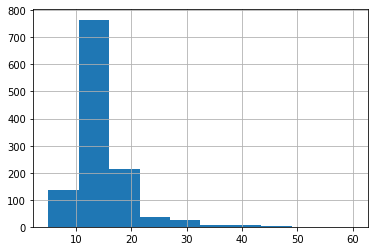

In [20]:
y_train.hist();

## Boxplot - to check outliers

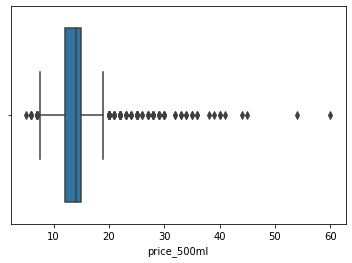

In [21]:
sns.boxplot(y_train)

## QQplot confirms there are outliers in high-valued part

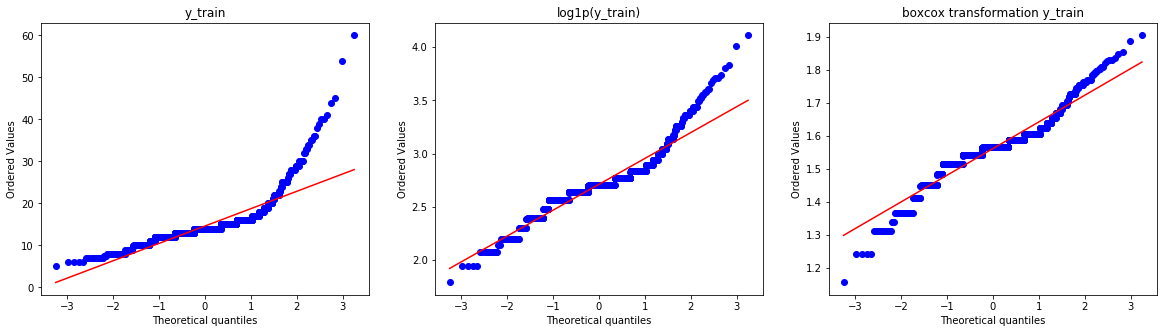

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
# distribution as in data
stats.probplot(y_train, plot=ax[0]);
ax[0].set_title('y_train')
# log y_train
stats.probplot(np.log1p(y_train), plot=ax[1]);
ax[1].set_title('log1p(y_train)')
# boxcox y_train
y_train_boxcox, _ = stats.boxcox(y_train)
stats.probplot((y_train_boxcox), plot=ax[2]);
ax[2].set_title('boxcox transformation y_train');

## Normality tests - distributon of Y feature is not normal (gaussian)

In [23]:
for data in [
    y_train,
    np.log1p(y_train),
    y_train_boxcox
    ]:

    print('\n')
    print('stats.normaltest: ', stats.normaltest(data))
    print('stats.shapiro: ', stats.shapiro(data))
    print('stats.kstest: ', stats.kstest((data-np.mean(data))/np.std(data,ddof=1), 'norm'))
    print('lilliefors: ', lilliefors(data))



stats.normaltest:  NormaltestResult(statistic=861.6780446606057, pvalue=7.7444398918545e-188)
stats.shapiro:  (0.7311403751373291, 4.302112402338978e-40)
stats.kstest:  KstestResult(statistic=0.23506652287828222, pvalue=2.0358771047639017e-58)
lilliefors:  (0.23506652287828222, 1.7299110560532045e-186)


stats.normaltest:  NormaltestResult(statistic=230.0156838020105, pvalue=1.1290908469796956e-50)
stats.shapiro:  (0.9028142094612122, 7.527595024878686e-27)
stats.kstest:  KstestResult(statistic=0.16591038692659, pvalue=3.815119101922144e-29)
lilliefors:  (0.16591038692659, 4.248682699129247e-91)


stats.normaltest:  NormaltestResult(statistic=84.09950699116123, pvalue=5.470463081752581e-19)
stats.shapiro:  (0.924923837184906, 6.2311278822239136e-24)
stats.kstest:  KstestResult(statistic=0.15564466316648295, pvalue=1.100900366590055e-25)
lilliefors:  (0.15564466316648295, 7.820309389477167e-80)


## remove outliers

In [24]:
train['sigmas'] = (train['price_500ml'] - np.mean(train['price_500ml'])) / np.std(train['price_500ml'])
train = train[abs(train['sigmas']) <= 3].drop('sigmas', axis=1)
X_train = train.drop(['price_500ml'], axis=1)
y_train = train['price_500ml']

## pairplot to visualize histograms and correlations
Looks like features ontap_since_days and rb_reviews_no have high ratio of low values

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 720x720 with 0 Axes>

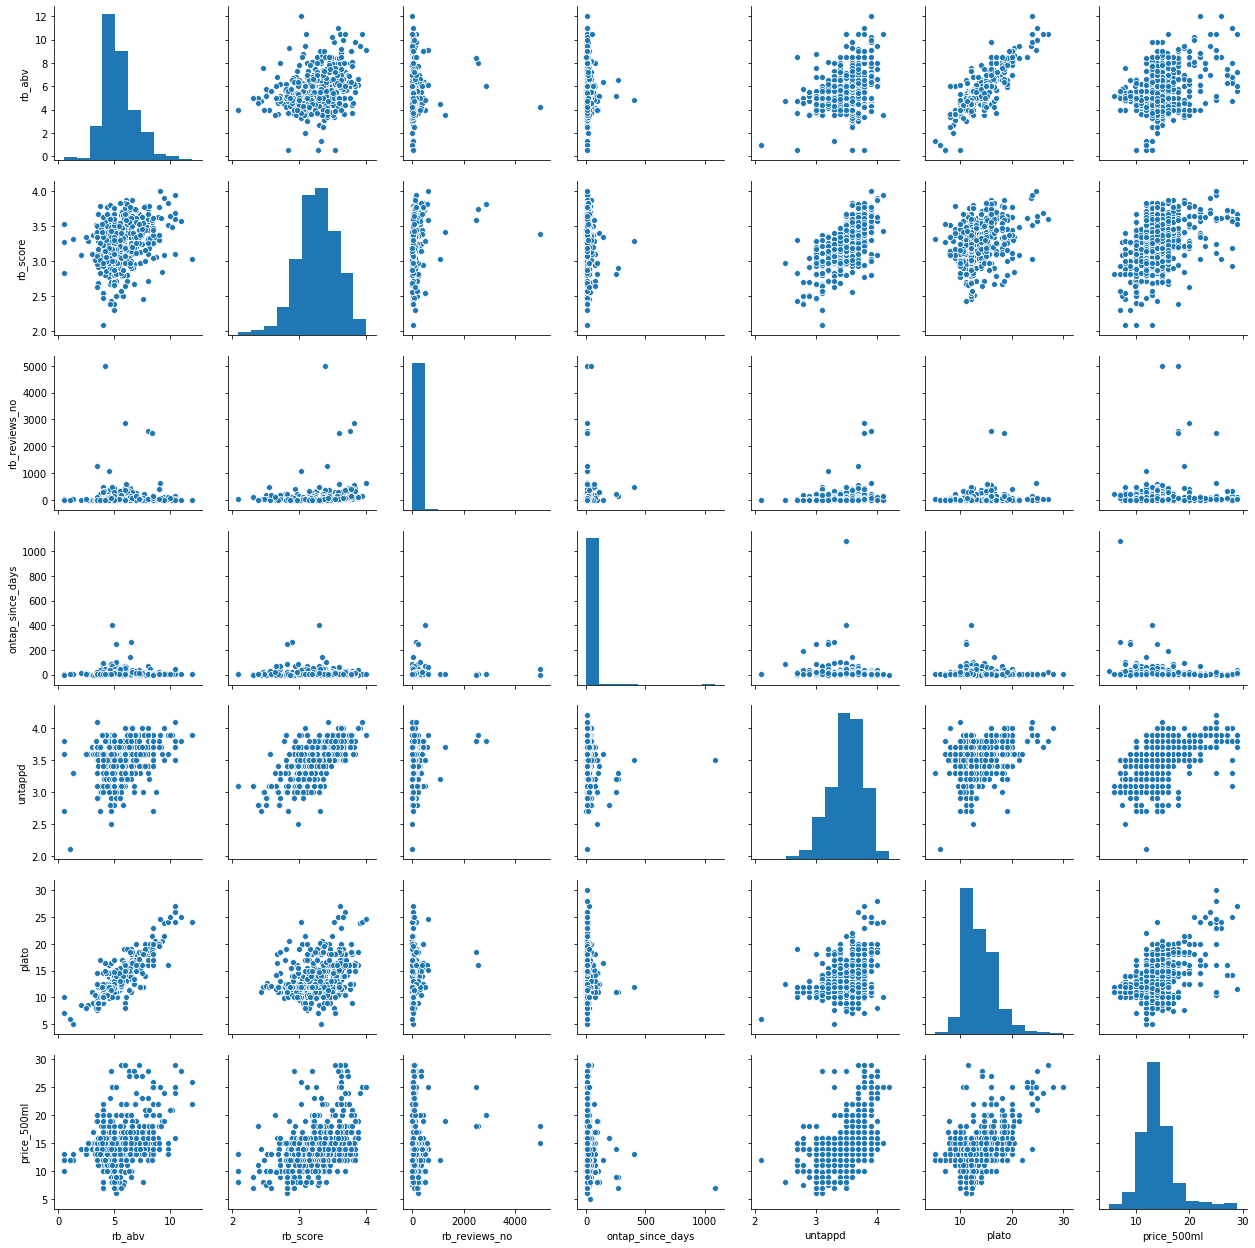

In [25]:
plt.figure(figsize=(10,10));
sns.pairplot(train);

## check ontap_since_days distribution

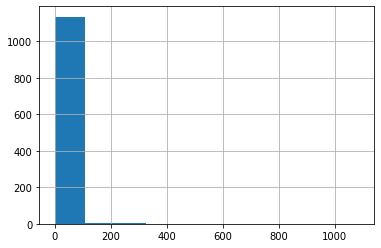

In [26]:
train['ontap_since_days'].hist()

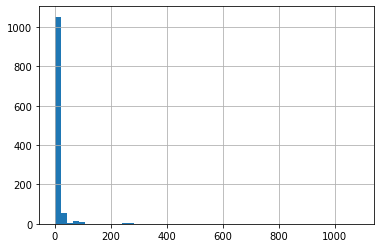

In [27]:
train['ontap_since_days'].hist(bins=50)

## check linear correlation between measures

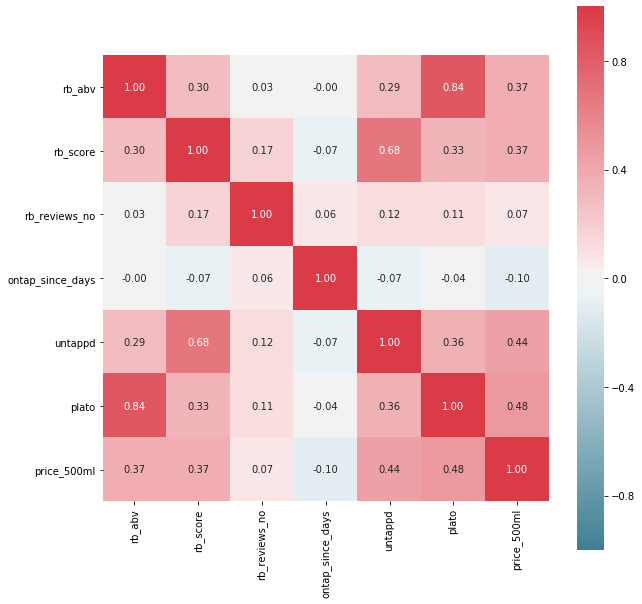

In [28]:
plt.figure(figsize=(10,10))
sns.heatmap(
    train.corr(), 
    vmax=1,
    vmin=-1,
    annot=True,
    square=True,
    cmap = sns.diverging_palette(220, 10, as_cmap=True),
    fmt='.2f'
);

# we have highly correlated feature pairs, so we drop:
* plato - highly correlated with rb_abv
* untappd - highly correlated with rb_score

In [29]:
for dataset in [X_train, X_test, train, test, df]:
    dataset.drop(['plato', 'untappd'], axis=1, inplace=True)

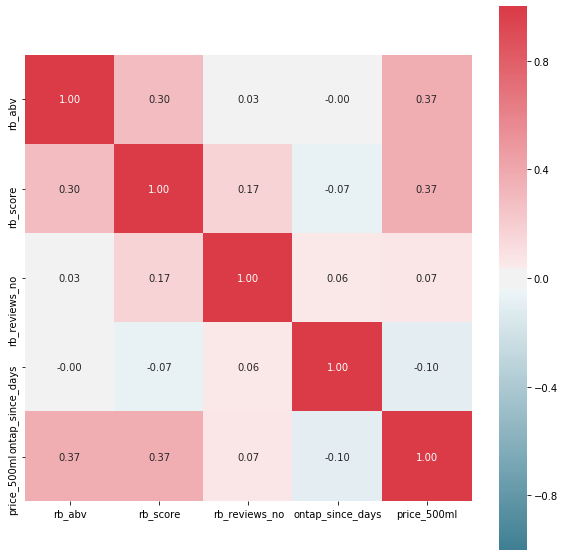

In [30]:
plt.figure(figsize=(10,10))
sns.heatmap(
    train.corr(), 
    vmax=1,
    vmin=-1,
    annot=True,
    square=True,
    cmap = sns.diverging_palette(220, 10, as_cmap=True),
    fmt='.2f'
);

# check equality of means between feature groups

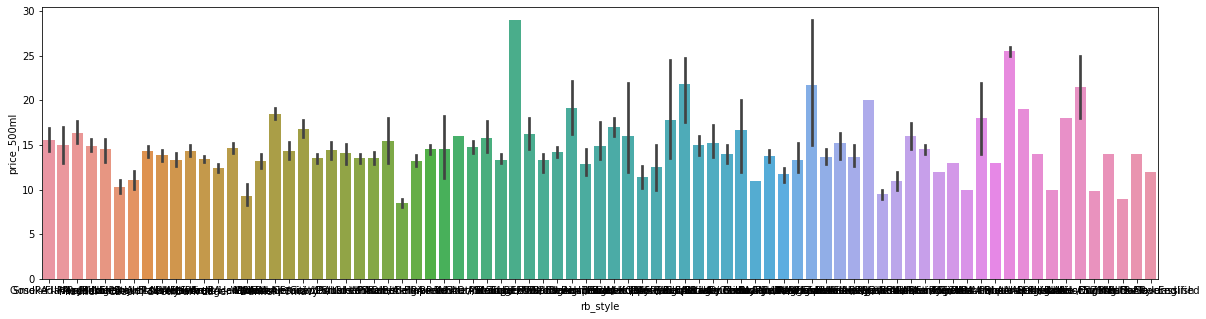

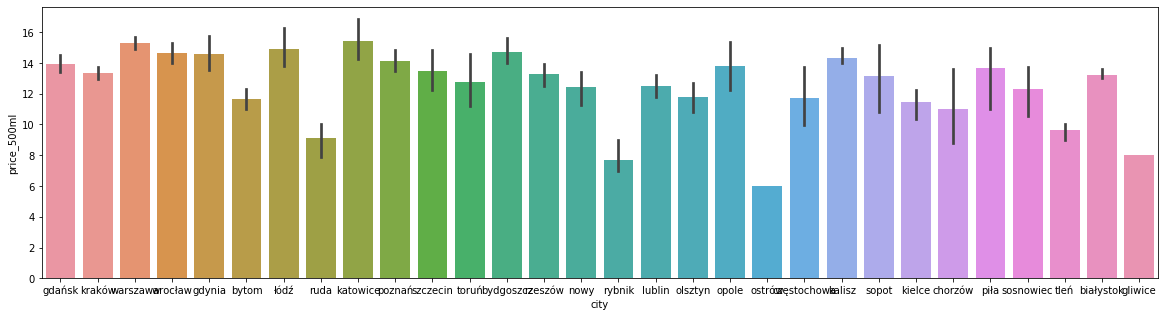

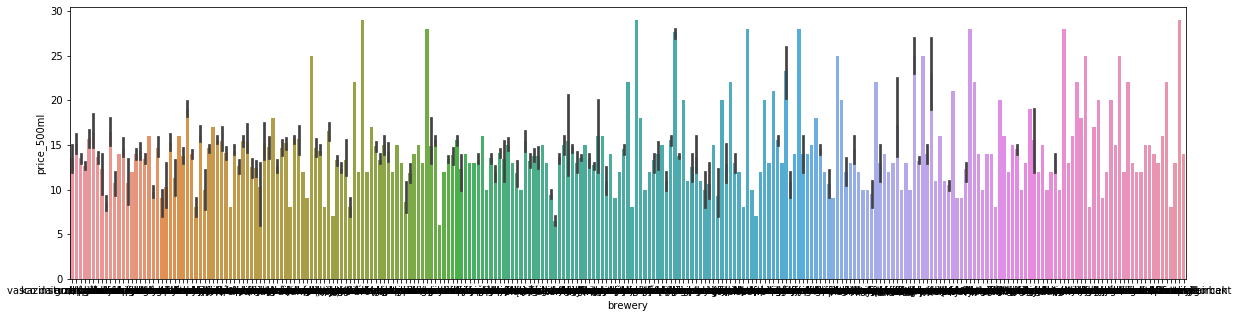

In [31]:
for feature in ['rb_style', 'city', 'brewery']:
    plt.figure(figsize=(20,5))
    sns.barplot(data=train, x=feature, y='price_500ml');
    plt.show()

## there are different means between groups, so we use all categorical features in modelling

# Modelling

## Preprocessor - feature transformations

### add custom transformator which aggregates category members with ratio less than chosen by user

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoryOtherRecoder(BaseEstimator, TransformerMixin):  
    """Recode fewer values into one category - Others"""

    def __init__(self, threshold_perc = None):
        """
        Called when initializing the classifier
        """
        self.threshold_perc = threshold_perc

    def fit(self, data, y=None):
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)
            
        self.variable_dictionary = {}
        for column in data.columns:
            freq_table = data[column].value_counts(dropna=True, normalize=True)
            categories = freq_table[freq_table > self.threshold_perc].index
            self.variable_dictionary[column] = categories
        
        return self

    def transform(self, data):
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)
            
        for column in data.columns:
            data[str(column)+'_rec'] = data[column].apply(lambda x: x if x in self.variable_dictionary.get(column) else 'Others')
        return data.loc[:, [col for col in data.columns if str(col).endswith('rec')]].values

### definition of feature transformation pipeline

In [33]:
numerical_feature_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean', copy = True, add_indicator=True)),
        ('scaler', StandardScaler())
    ]
)

categorical_feature_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('other_rare', CategoryOtherRecoder(0.5)),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)                              

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_feature_transformer, X_train.select_dtypes('number').columns),
        ('cat', categorical_feature_transformer, X_train.select_dtypes('object').columns)
    ]
)

# Models

## Baseline
For the baseline we assume average price as baseline prediction

In [34]:
df_prediction = pd.DataFrame(y_test.copy())
df_prediction['prediction'] = y_train.mean()

print('\n')
print('R2: ', r2_score(df_prediction['price_500ml'], df_prediction['prediction']))
print('MSE: ', mean_squared_error(df_prediction['price_500ml'], df_prediction['prediction']))
print('RMSE: ', np.sqrt(mean_squared_error(df_prediction['price_500ml'], df_prediction['prediction'])))

baseline_RMSE = np.sqrt(mean_squared_error(df_prediction['price_500ml'], df_prediction['prediction']))



R2:  -0.014519212977750495
MSE:  30.741706567938692
RMSE:  5.544520409191285


## Basic models comparison

In [35]:
models = {
    'LR' : LinearRegression(normalize=True, n_jobs=-1, ), 
    'Lasso' : Lasso(random_state=myseed, alpha=0.1, normalize=True), 
    'Ridge' : Ridge(random_state=myseed, alpha=0.1, normalize=True), 
    'Tree' : DecisionTreeRegressor(), 
    'RF' : RandomForestRegressor(n_jobs=-1), 
    'SVR' : SVR(), 
    'MLP' : MLPRegressor(learning_rate_init=0.1, alpha=0.01), 
    'KNN' : KNeighborsRegressor(n_jobs=-1), 
    'BR' : BayesianRidge(), 
    'XGB' : XGBRegressor(n_jobs=-1)
}

results = pd.DataFrame(columns=['model', 'mse', 'rmse'])

for model_name in models:
    print(model_name)
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', models[model_name])
        ]
                    )

    clf = GridSearchCV(model, param_grid={}, cv=5, scoring='neg_mean_squared_error')
    clf.fit(X_train, y_train)
    
    results = results.append(pd.DataFrame(
    {
        'model' : model_name,
        'mse' : -1 * clf.best_score_,
        'rmse' : np.sqrt(-1 * clf.best_score_)
    }, index=[0]
    )
)

LR
Lasso


c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Ridge
Tree
RF


c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

SVR


c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureW

MLP
KNN


c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BR


c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGB
[00:07:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### Basic models comparison

In [36]:
pd.options.display.float_format = '{:.4f}'.format
results

,model,mse,rmse
0,LR,10.1385,3.1841
0,Lasso,12.0836,3.4762
0,Ridge,10.1449,3.1851
0,Tree,14.1865,3.7665
0,RF,10.1466,3.1854
0,SVR,9.7524,3.1229
0,MLP,10.1127,3.1800
0,KNN,10.5670,3.2507
0,BR,10.1424,3.1847
0,XGB,9.4192,3.0691


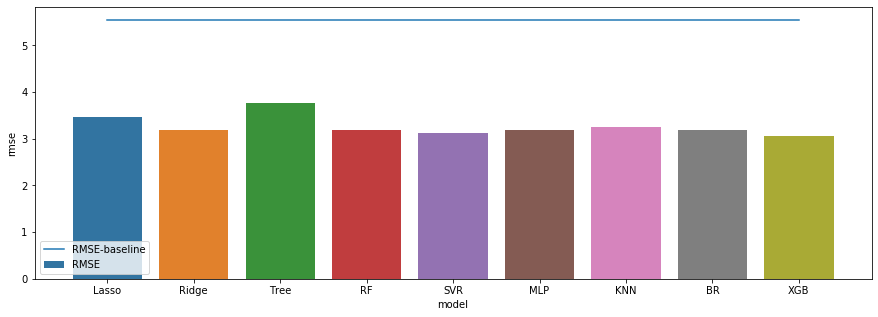

In [37]:
plt.figure(figsize=(15,5))
sns.barplot(x='model', y='rmse', data=results[results['model']!='LR'], label='RMSE')
sns.lineplot(x=results[results['model']!='LR']['model'], y=baseline_RMSE, label='RMSE-baseline')

## Hyperparameters optimisation for chosen models

In [38]:
final_models = pd.DataFrame(columns=['best_params', 'mse', 'rmse'])

### Ridge regression

In [39]:
models = {'Ridge' : Ridge(alpha=1, normalize=False, random_state = myseed)}

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models['Ridge'])
    ]
)

parameters = {'regressor__alpha' : [0.3, 0.25, 0.2, 0.1, 0.01]}

clf = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

final_models = pd.concat([
    final_models, 
    pd.DataFrame(
        {
            'best_params' : str(clf.best_params_),
            'mse' : -1 * clf.best_score_,
            'rmse' : np.sqrt(-1 * clf.best_score_)
        }, index=[list(models.keys())[0]]
        )
])



c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Random forest

In [40]:
models = {
    'RF' : RandomForestRegressor(random_state = myseed, n_estimators=5, max_depth=5, min_samples_leaf=5, n_jobs=-1)
}

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models['RF'])
                     ]
                )

parameters = {'regressor__n_estimators' : [5, 50, 100, 200],
             'regressor__min_samples_leaf' : [2, 5, 10, 25]
             }

clf = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

final_models = pd.concat([
    final_models, 
    pd.DataFrame(
        {
            'best_params' : str(clf.best_params_),
            'mse' : -1 * clf.best_score_,
            'rmse' : np.sqrt(-1 * clf.best_score_)
        }, index=[list(models.keys())[0]]
    )
])

### SVR

In [41]:
models = {'SVR' : SVR(C=1, gamma='scale')}

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models['SVR'])
    ]
)

parameters = {
    'regressor__kernel': ('linear', 'rbf','poly'), 
    'regressor__C':[1, 10, 100, 1000],
    'regressor__epsilon':[0.1, 0.2, 0.3, 0.5, 0.8]
}

clf = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

final_models = pd.concat([
    final_models, 
    pd.DataFrame(
        {
            'best_params' : str(clf.best_params_),
            'mse' : -1 * clf.best_score_,
            'rmse' : np.sqrt(-1 * clf.best_score_)
        }, index=[list(models.keys())[0]]
        )
])

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### XGBoost

In [42]:
models = {'XGB' : XGBRegressor(objective = 'reg:squarederror')}

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models['XGB'])
    ]
)

parameters = {
    'regressor__learning_rate': [0.03, 0.05, 0.07, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_child_weight': [2, 5, 10],
    'regressor__colsample_bytree': [0.7],
    'regressor__n_estimators': [100, 300, 500]
}

clf = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

final_models = pd.concat([
    final_models, 
    pd.DataFrame(
        {
            'best_params' : str(clf.best_params_),
            'mse' : -1 * clf.best_score_,
            'rmse' : np.sqrt(-1 * clf.best_score_)
        }, index=[list(models.keys())[0]]
        )
])

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureW

### MLP Regressor

In [43]:
models = {'MLP' : MLPRegressor(random_state=myseed)}

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models['MLP'])
    ]
)

parameters = {
    'regressor__hidden_layer_sizes': [(100), (100, 10), (50)],
    'regressor__activation' : ['relu', 'tanh'],
    'regressor__alpha' : [0.0001, 0.001, 0.01, 0.1]
}

clf = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

final_models = pd.concat([
    final_models, 
    pd.DataFrame(
        {
            'best_params' : str(clf.best_params_),
            'mse' : -1 * clf.best_score_,
            'rmse' : np.sqrt(-1 * clf.best_score_)
        }, index=[list(models.keys())[0]]
        )
])

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochasti

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochasti

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochasti

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochasti

c:\users\michl\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Summary

In [44]:
pd.set_option('display.max_colwidth', -1)
final_models

,best_params,mse,rmse
Ridge,{'regressor__alpha': 0.3},10.1374,3.1839
RF,"{'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 200}",9.4436,3.0730
SVR,"{'regressor__C': 100, 'regressor__epsilon': 0.8, 'regressor__kernel': 'rbf'}",9.4701,3.0774
XGB,"{'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__min_child_weight': 2, 'regressor__n_estimators': 100}",9.3867,3.0638
MLP,"{'regressor__activation': 'relu', 'regressor__alpha': 0.1, 'regressor__hidden_layer_sizes': (100, 10)}",9.3332,3.0550


# FINAL MODEL

In [45]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
       min_samples_leaf = 2, n_estimators = 200
    ))
    ]
)

model.fit(X_train, y_train)

print(
    'TEST (Holdout set) RMSE: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)), "\n"
)


TEST (Holdout set) RMSE:  4.981377261593855 



# FUTURE
* better quality of data - see below analysis of RMSE by rb_style, all beers with empty rb_style has worse prediction results
* additional features?
    - demographic data
    - craft pub data - how long does it exists, how many taps are in pub, do they have food in same place etc
    - statistical data (average salary in voivodeship, alcohol consumption by voivodeship)
* check in which style prediction is missed the most? which city?


# Appendix - why RMSE is so bad?

### by rb_style

In [46]:
def rmse_group(group):
    return np.sqrt(mean_squared_error(group['prediction'], group['real']))

In [125]:
predictions = pd.DataFrame(y_test)
predictions.columns = ['real']
predictions['prediction'] = model.predict(X_test)
predictions['rb_style'] = X_test['rb_style']
predictions['style'] = X_test['style']
predictions['beer_name'] = X_test['beer_name']
predictions['brewery'] = X_test['brewery']
# predictions.head(5)

In [121]:
predictions.groupby('rb_style').apply(rmse_group).sort_values(ascending=False).head(10)

rb_style
BarleyWine / WheatWine / RyeWine   13.5576
Porter - Baltic                    12.5054
Stout - Flavored                   12.4233
Lambic - Unblended Jonge / Oude    10.0292
Porter - Imperial                  8.5161 
Stout - Imperial Flavored          4.8240 
Lambic - Faro                      4.3565 
Sour / Wild Beer                   4.2812 
Flavored - Other                   3.9713 
Dark Lager - Dunkel / Tmavý        3.7038 
dtype: float64

In [126]:
print('RMSE for empty rb_style: ', np.sqrt(
    mean_squared_error(predictions.loc[predictions['rb_style'].isna(), 'real'], 
                       predictions.loc[predictions['rb_style'].isna(), 'prediction']
                      )
)
     )

RMSE for empty rb_style:  18.826261624172307


In [127]:
print('RMSE for non-empty rb_style: ', np.sqrt(
    mean_squared_error(predictions.loc[~predictions['rb_style'].isna(), 'real'], 
                       predictions.loc[~predictions['rb_style'].isna(), 'prediction']
                      )
)
     )

RMSE for non-empty rb_style:  4.508833009222314


### by brewery

In [122]:
predictions.groupby('brewery').apply(rmse_group).sort_values(ascending=False).head(10)

brewery
frizzante            36.8544
brouwerij de molen   29.5825
to ol                24.2219
founders             23.0114
de molen             22.0698
dieu du ciel         17.0153
wokanda              12.5087
kormoran             10.0327
mikkeller            10.0292
hanušovic            8.8743 
dtype: float64

In [140]:
predictions[
    predictions['brewery'].isin(
        list(predictions.groupby('brewery').apply(rmse_group).sort_values(ascending=False).head(10).keys())
    )
]

,real,prediction,rb_style,style,beer_name,brewery
1868,35.0000,17.9847,Stout - Flavored,strong stout + cococa + vanilla,aphrodisiaque,dieu du ciel
1328,36.0000,22.4424,BarleyWine / WheatWine / RyeWine,barley wine z jarzębiną,barlow sorbus,kormoran
1698,44.0000,14.4175,None,imperial stout bowmore ba,hel&verdoemenis bowmore ba,brouwerij de molen
665,35.0000,12.9302,None,hazelnut ris,hell & verdoemenis hazelnoot,de molen
1864,38.0000,13.7781,None,imperial coffee stout,goliat bourbon edition,to ol
1106,33.0000,20.4913,Porter - Baltic,imperialny porter bałtycki ba jack danielu0027s tennessee whiskey,świadek koronny,wokanda
919,9.0000,13.1834,Pilsener - Czech / Svetlý,lager,warmińskie rewolucje,kormoran
1465,9.0000,17.8743,None,svetly lezak,holba premium,hanušovic
1816,25.0000,14.9708,Lambic - Unblended Jonge / Oude,lambic,vesterbro spontanale,mikkeller
1785,37.0000,13.9886,None,chocolate and coffee bourbon barrel aged stout,kbs kentucky breakfast stout,founders


### too much nan's in rb_style to make good prediction

In [143]:
predictions.isna().mean()

real         0.0000
prediction   0.0000
rb_style     0.2584
style        0.0134
beer_name    0.0000
brewery      0.0000
dtype: float64